In [11]:
import pandas as pd
import datetime as dt
import numpy as np
import math
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, BayesianRidge
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
# from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# sns.set_theme()
sns.set_palette('rocket_r')
# sns.color_palette("rocket")

## To do:
1. Preprocess:
   
   a. Standardize
   
   b. Split Data
   
   c. Normalize
3. Extract import features using RandomForestClassifier
4. Run all models storing their accuracy and f1-scores in a table

In [13]:
data = pd.read_csv('../../data/model_features.csv')
data.shape

(1192, 82)

In [14]:
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,...,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,3mean_plus_minus,3mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,0,1,0,1,0,94.171478,109.031485,1.157797,67.0,8.250000,...,0.555556,1.000000,0.178571,0.000000,0.833333,16.333333,7.666667,5,0,NaN
1,1,1,0,1,0,83.955939,105.172414,1.252710,72.0,9.405172,...,0.615385,0.000000,0.238095,0.000000,0.400000,16.333333,5.666667,3,4,NaN
2,0,1,0,1,0,83.955939,105.172414,1.252710,72.0,9.405172,...,0.545455,0.000000,0.444444,0.000000,0.600000,16.000000,4.333333,4,2,NaN
3,0,1,0,1,0,97.527473,109.981685,1.127700,64.0,7.580882,...,0.250000,1.000000,0.192308,0.000000,0.666667,10.000000,4.000000,8,0,NaN
4,1,1,0,1,0,100.912698,103.333333,1.023987,70.0,8.979167,...,0.500000,0.333333,NaN,0.666667,0.500000,-7.666667,0.000000,0,0,NaN


In [20]:
models = {
    'Bayesian Ridge Regression':[BayesianRidge(), False, 'regression', 'Linear'],
    'Decision Tree Classifier':[DecisionTreeClassifier(random_state=42), False, 'classification', 'Tree'],
    'Gaussian Naïve Bayes':[GaussianNB(), False, 'classification', 'Probabilistic'],
    'Gradient Boosting for Classification':[GradientBoostingClassifier(random_state=42), False, 'classification', 'Tree'],
    'Gradient Boosting for Regression':[GradientBoostingRegressor(random_state=42), False, 'regression', 'Tree'],
    'Histogram-based Gradient Boosting Classification Tree':[HistGradientBoostingClassifier(random_state=42), True, 'classification', 'Tree'],
    'Logistic Regression':[LogisticRegression(random_state=42), False, 'classification', 'Linear'],
    'Random Forest Classifier':[RandomForestClassifier(random_state=42), False, 'classification', 'Tree'],
    'Stochastic Gradient Descent Classifier':[SGDClassifier(random_state=42), False, 'classification', 'Linear'],
    'Epsilon-Support Vector Regression (SVR)':[SVR(), False, 'regression', 'Non-Probabilistic'],
    'Support Vector Machines Classifier':[SVC(random_state=42), False, 'classification', 'Non-Probabilistic'],
    'Extreme Gradient Boosting (Xgboost) Classifier':[XGBClassifier(random_state=42), False, 'classification', 'Tree']
}

In [21]:
# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [22]:
def transform_to_binary(x):
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return round(x)

In [23]:
results = {}
for model_type in models.keys():
    start = dt.datetime.now()
    # Remove fields with NaN values if model can't handel them
    if not models[model_type][1]:
        df = data.dropna(axis=1).copy()
    else:
        df = data.copy()

    # Split training and test data
    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    # Initialize the StratifiedKFold with 5 folds
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # # Standardize/Normalize the data
    # if models[model_type][2] == 'regression':
    #     scaler = MinMaxScaler() #normalization
    # else:
    #     scaler = StandardScaler() #standardization

    model = models[model_type][0]
    
    # Perform 5-fold cross-validation
    f1_scores = []
    accuracies = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Standardize and normalize the data using the same scaler
        for scaler in [StandardScaler(), MinMaxScaler()]:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
    
        # Train the model on the training set
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if models[model_type][2] == 'regression':
            # define vectorized sigmoid
            sigmoid_v = np.vectorize(sigmoid)
            y_pred_sig = sigmoid_v(np.array(y_pred))
            y_pred = list(map(round,y_pred_sig))

        f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))

    f1_score_strat = sum(f1_scores) / len(f1_scores)
    f1_std = np.std(f1_scores)
    accuracy_score_strat = sum(accuracies) / len(accuracies)
    acc_std = np.std(accuracies)

    runtime = (dt.datetime.now() - start).seconds
    results[model_type] = [models[model_type][3], f1_score_strat,f1_std, accuracy_score_strat,acc_std,runtime]
    print(f'{model_type}\nAccuracy: {accuracy_score_strat}\nF1-Score: {f1_score_strat}\nRuntime: {runtime}s\n')

Bayesian Ridge Regression
Accuracy: 0.5335607046165747
F1-Score: 0.6812002585149883
Runtime: 0s

Decision Tree Classifier
Accuracy: 0.6493512886326078
F1-Score: 0.6526486463217621
Runtime: 0s

Gaussian Naïve Bayes
Accuracy: 0.6963011145880946
F1-Score: 0.6975608851109761
Runtime: 0s

Gradient Boosting for Classification
Accuracy: 0.7147638971906753
F1-Score: 0.7147388534479324
Runtime: 5s

Gradient Boosting for Regression
Accuracy: 0.5335782848704335
F1-Score: 0.681967069011411
Runtime: 4s

Histogram-based Gradient Boosting Classification Tree
Accuracy: 0.8255476249077038
F1-Score: 0.8263869030076071
Runtime: 10s

Logistic Regression
Accuracy: 0.7390809043282586
F1-Score: 0.742306180225426
Runtime: 0s

Random Forest Classifier
Accuracy: 0.6996589430751381
F1-Score: 0.697418663764274
Runtime: 1s

Stochastic Gradient Descent Classifier
Accuracy: 0.7039485250167012
F1-Score: 0.7316737367390287
Runtime: 0s

Epsilon-Support Vector Regression (SVR)
Accuracy: 0.5696740620934567
F1-Score: 0.69

In [24]:
df_results = pd.DataFrame(results).T
df_results.columns = ['model_type','f1_score','f1_score_σ','accuracy_score','accuracy_σ','runtime']
df_results.sort_values('f1_score', ascending=False).to_csv('../../data/model_summary_phase1.csv')

In [25]:
df_results = df_results.sort_values('f1_score', ascending=False)
df_results

,model_type,f1_score,f1_score_σ,accuracy_score,accuracy_σ,runtime
Histogram-based Gradient Boosting Classification Tree,Tree,0.826387,0.024335,0.825548,0.024358,10
Logistic Regression,Linear,0.742306,0.020906,0.739081,0.021953,0
Stochastic Gradient Descent Classifier,Linear,0.731674,0.008788,0.703949,0.044594,0
Gradient Boosting for Classification,Tree,0.714739,0.024898,0.714764,0.025494,5
Extreme Gradient Boosting (Xgboost) Classifier,Tree,0.713,0.023575,0.713052,0.024676,1
Support Vector Machines Classifier,Non-Probabilistic,0.710901,0.020378,0.708882,0.019786,0
Gaussian Naïve Bayes,Probabilistic,0.697561,0.020735,0.696301,0.01743,0
Random Forest Classifier,Tree,0.697419,0.029134,0.699659,0.026698,1
Epsilon-Support Vector Regression (SVR),Non-Probabilistic,0.695363,0.010771,0.569674,0.022368,0
Gradient Boosting for Regression,Tree,0.681967,0.005096,0.533578,0.010753,4


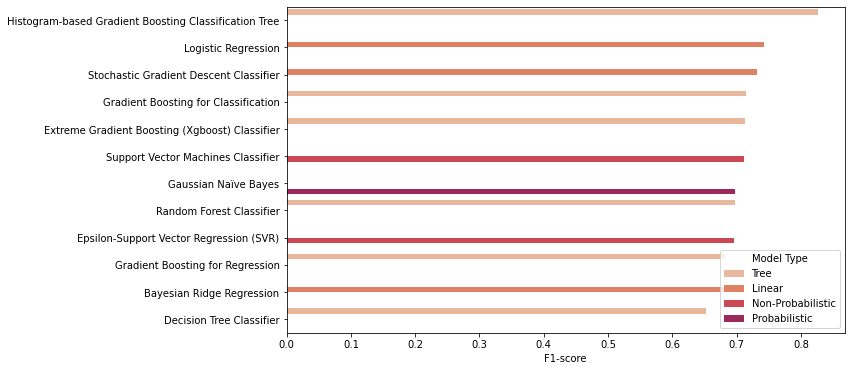

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, y=df_results.index, x='f1_score', hue='model_type')

# plt.title('Figure 1 - Attempted Models Ranked by F1-score')
plt.ylabel(None)
plt.xlabel('F1-score')
plt.legend(title='Model Type')
plt.savefig('../../visuals/models_ranked_by_f1_score.png', bbox_inches='tight')

## Identify important features using Random Forest Classifier

In [27]:
# Split training and test data
df = data.fillna(0)
# df = data.copy()
X = df.iloc[:,1:]
y = df.iloc[:,0]

rf_model = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [28]:
n = 10
feature_importance = {key:value for key,value in sorted(zip(data.columns.tolist()[1:], rf_model.feature_importances_), key=lambda x: x[1], reverse=True)}
top_features = list(feature_importance.keys())[:n]

In [29]:
feature_importance

{'upset_rate': 0.08370922915090535,
 'upset_rate_opp': 0.07622657398360023,
 'srs': 0.03464868862922176,
 'srs_opp': 0.03151689724806827,
 'sos': 0.023234536124206798,
 'sos_opp': 0.021556767835243237,
 'fan_favorite_opp': 0.019122346985211786,
 'fan_favorite': 0.017234900017654955,
 'game_win_rate_opp': 0.01702266456023221,
 'underdog': 0.016196931968765982,
 'te': 0.015867029436348698,
 'game_win_rate': 0.015125116053115228,
 'conf_rank_opp': 0.013974582285009236,
 'matchup_win_rate': 0.013917944803264042,
 '3mean_plus_minus_opp': 0.013773890285817601,
 'underdog_opp': 0.013524984107037528,
 'oe_opp': 0.013273114004841373,
 'choke_rate': 0.013136880012414554,
 'oe': 0.012887129673808903,
 '3mean_plus_minus': 0.012344299434102583,
 'pf': 0.012335286735727284,
 'choke_rate_opp': 0.01202959655995196,
 'gpt_sent_score_avg_opp': 0.011806525727830346,
 'gpt_sent_score_avg': 0.011248850770772496,
 'te_opp': 0.011145580714745931,
 'orb': 0.010977425134289964,
 'stl_opp': 0.01094482869325554,

In [30]:
top_features

['upset_rate',
 'upset_rate_opp',
 'srs',
 'srs_opp',
 'sos',
 'sos_opp',
 'fan_favorite_opp',
 'fan_favorite',
 'game_win_rate_opp',
 'underdog']

## Run models only using top features

In [31]:
results = {}
data1 = data[['won']+top_features]
for model_type in models.keys():
    start = dt.datetime.now()
    # Remove fields with NaN values if model can't handel them
    if not models[model_type][1]:
        df = data1.dropna(axis=1).copy()
    else:
        df = data1.copy()

    # Split training and test data
    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    # Initialize the StratifiedKFold with 5 folds
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # # Standardize/Normalize the data
    # if models[model_type][2] == 'regression':
    #     scaler = MinMaxScaler() #normalization
    # else:
    #     scaler = StandardScaler() #standardization

    model = models[model_type][0]
    
    # Perform 5-fold cross-validation
    f1_scores = []
    accuracies = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Standardize and normalize the data using the same scaler
        for scaler in [StandardScaler(), MinMaxScaler()]:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
    
        # Train the model on the training set
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if models[model_type][2] == 'regression':
            # define vectorized sigmoid
            sigmoid_v = np.vectorize(sigmoid)
            y_pred_sig = sigmoid_v(np.array(y_pred))
            y_pred = list(map(round,y_pred_sig))

        f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))

    f1_score_strat = sum(f1_scores) / len(f1_scores)
    f1_std = np.std(f1_scores)
    accuracy_score_strat = sum(accuracies) / len(accuracies)
    acc_std = np.std(accuracies)

    runtime = (dt.datetime.now() - start).seconds
    results[model_type] = [models[model_type][3], f1_score_strat,f1_std, accuracy_score_strat,acc_std,runtime]
    print(f'{model_type}\nAccuracy: {accuracy_score_strat}\nF1-Score: {f1_score_strat}\nRuntime: {runtime}s\n')

Bayesian Ridge Regression
Accuracy: 0.5343975247002566
F1-Score: 0.6816148727630671
Runtime: 0s

Decision Tree Classifier
Accuracy: 0.639305931577652
F1-Score: 0.6383696789547753
Runtime: 0s

Gaussian Naïve Bayes
Accuracy: 0.6929714145072255
F1-Score: 0.697482119565868
Runtime: 0s

Gradient Boosting for Classification
Accuracy: 0.7147533490383602
F1-Score: 0.7155084157907696
Runtime: 0s

Gradient Boosting for Regression
Accuracy: 0.5344045568018002
F1-Score: 0.6816169630001142
Runtime: 0s

Histogram-based Gradient Boosting Classification Tree
Accuracy: 0.7952920080165957
F1-Score: 0.7957685805621927
Runtime: 3s

Logistic Regression
Accuracy: 0.7256777187862593
F1-Score: 0.7302753714105379
Runtime: 0s

Random Forest Classifier
Accuracy: 0.7030273197144966
F1-Score: 0.7042900010454824
Runtime: 0s

Stochastic Gradient Descent Classifier
Accuracy: 0.6660701100523891
F1-Score: 0.6821490920334903
Runtime: 0s

Epsilon-Support Vector Regression (SVR)
Accuracy: 0.5595829963784676
F1-Score: 0.69

In [32]:
df_results = pd.DataFrame(results).T
df_results.columns = ['model_type','f1_score','f1_score_σ','accuracy_score','accuracy_σ','runtime']
df_results.sort_values('f1_score', ascending=False).to_csv('../../data/model_summary_phase2.csv')
df_results.sort_values('f1_score', ascending=False)

,model_type,f1_score,f1_score_σ,accuracy_score,accuracy_σ,runtime
Histogram-based Gradient Boosting Classification Tree,Tree,0.795769,0.015921,0.795292,0.01353,3
Logistic Regression,Linear,0.730275,0.024929,0.725678,0.024897,0
Gradient Boosting for Classification,Tree,0.715508,0.025383,0.714753,0.017996,0
Extreme Gradient Boosting (Xgboost) Classifier,Tree,0.707714,0.030635,0.708889,0.020891,0
Random Forest Classifier,Tree,0.70429,0.03049,0.703027,0.024861,0
Gaussian Naïve Bayes,Probabilistic,0.697482,0.010942,0.692971,0.012653,0
Support Vector Machines Classifier,Non-Probabilistic,0.695379,0.01903,0.69045,0.021597,0
Epsilon-Support Vector Regression (SVR),Non-Probabilistic,0.691958,0.010194,0.559583,0.024701,0
Stochastic Gradient Descent Classifier,Linear,0.682149,0.126023,0.66607,0.042914,0
Gradient Boosting for Regression,Tree,0.681617,0.005969,0.534405,0.011181,0


In [33]:
df_results_total = pd.read_csv('../../data/model_summary_phase1.csv').rename(columns={'Unnamed: 0':'model'})
df_results_top10 = pd.read_csv('../../data/model_summary_phase2.csv').rename(columns={'Unnamed: 0':'model'})

In [34]:
df_results_top10['model'] = df_results_top10['model'].apply(lambda x:x+'_10')

In [35]:
combined_results = pd.concat([df_results_total,df_results_top10]).set_index('model').sort_values('f1_score', ascending=False)
combined_results

,model_type,f1_score,f1_score_σ,accuracy_score,accuracy_σ,runtime
model,,,,,,
Histogram-based Gradient Boosting Classification Tree,Tree,0.826387,0.024335,0.825548,0.024358,10
Histogram-based Gradient Boosting Classification Tree_10,Tree,0.795769,0.015921,0.795292,0.013530,3
Logistic Regression,Linear,0.742306,0.020906,0.739081,0.021953,0
Stochastic Gradient Descent Classifier,Linear,0.731674,0.008788,0.703949,0.044594,0
Logistic Regression_10,Linear,0.730275,0.024929,0.725678,0.024897,0
Gradient Boosting for Classification_10,Tree,0.715508,0.025383,0.714753,0.017996,0
Gradient Boosting for Classification,Tree,0.714739,0.024898,0.714764,0.025494,5
Extreme Gradient Boosting (Xgboost) Classifier,Tree,0.713000,0.023575,0.713052,0.024676,1
Support Vector Machines Classifier,Non-Probabilistic,0.710901,0.020378,0.708882,0.019786,0


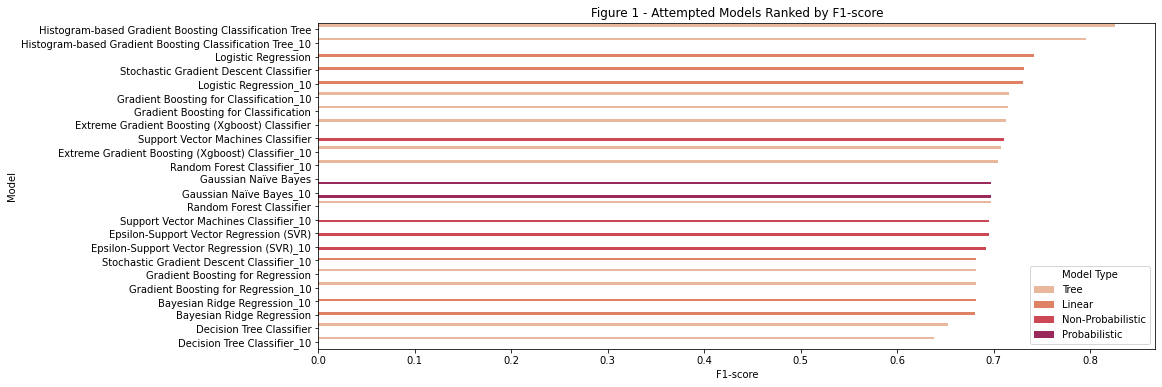

In [36]:
plt.figure(figsize=(15,6))
sns.barplot(data=combined_results, y=combined_results.index, x='f1_score', hue='model_type')

plt.title('Figure 1 - Attempted Models Ranked by F1-score')
plt.ylabel('Model')
plt.xlabel('F1-score')
plt.legend(title='Model Type')

<AxesSubplot:xlabel='runtime', ylabel='model'>

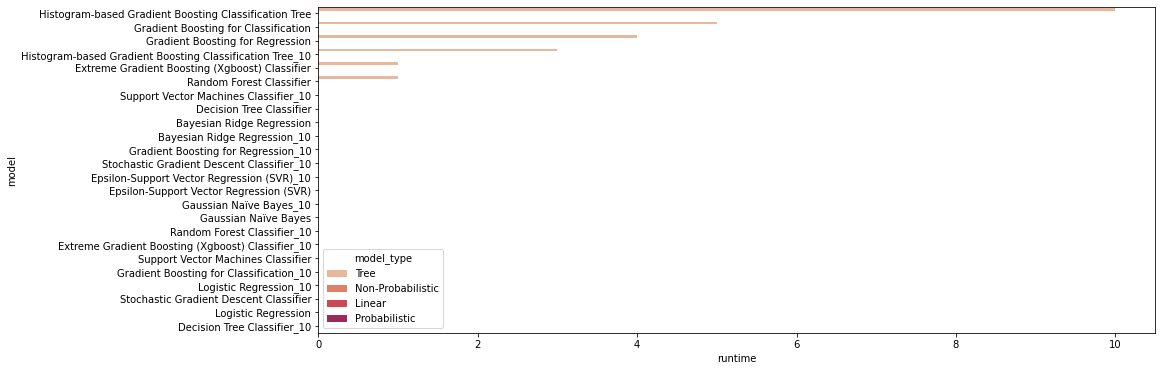

In [37]:
plt.figure(figsize=(15,6))
combined_results_runtime = combined_results.sort_values('runtime',ascending=False)
sns.barplot(data=combined_results_runtime, y=combined_results_runtime.index, x='runtime', hue='model_type')

<AxesSubplot:xlabel='runtime', ylabel='f1_score'>

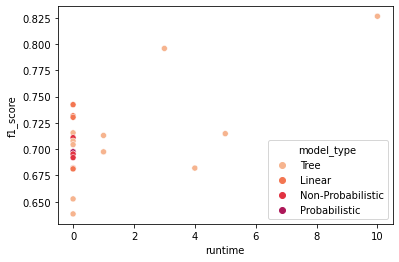

In [38]:
sns.scatterplot(data=combined_results,x='runtime',y='f1_score',hue='model_type',)

## Tune Top Three Models:

- Histogram-based Gradient Boosting Classification Tree
- Logistic Regression
- Stochastic Gradient Descent Classifier

In [39]:
models_to_tune = {
    'Histogram-based Gradient Boosting Classification Tree':[HistGradientBoostingClassifier(), True, 'classification', 'Tree'],
    'Logistic Regression':[LogisticRegression(), False, 'classification', 'Linear'],
    'Stochastic Gradient Descent Classifier':[SGDClassifier(), False, 'classification', 'Linear'],
}

In [48]:
tuned_results = {}

## Tune Histogram-based Gradient Boosting Classification Tree

In [49]:
model_name = 'Best Histogram-based Gradient Boosting Classification Tree'
start = dt.datetime.now()
df = data.copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


hgb_classifier = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [x/100 for x in list(range(2,9))],
    'max_iter': [100],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [15, 20, 25]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hgb_grid_search = GridSearchCV(hgb_classifier, param_grid, cv=stratified_cv, scoring='f1')
hgb_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", hgb_grid_search.best_params_)

# Get the best model from the grid search
best_hgb_model = hgb_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_hgb_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', hgb_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in hgb_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_iter': 100, 'min_samples_leaf': 15}
Best Histogram-based Gradient Boosting Classification Tree
CV Training Best F1-Score: 0.8038631686799734
Test F1-Score: 0.8290598290598291
Test Accuracy: 0.8326359832635983
Tuning Runtime: 435 sec


#### Try without scaling

In [50]:
model_name = 'Best Histogram-based Gradient Boosting Classification Tree without Scaling'
start = dt.datetime.now()
df = data.copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


hgb_classifier = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [x/100 for x in list(range(2,9))],
    'max_iter': [100],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [15, 20, 25]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hgb_grid_search = GridSearchCV(hgb_classifier, param_grid, cv=stratified_cv, scoring='f1')
hgb_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", hgb_grid_search.best_params_)

# Get the best model from the grid search
best_hgb_model = hgb_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_hgb_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', hgb_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in hgb_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

Best Hyperparameters: {'learning_rate': 0.08, 'max_depth': 10, 'max_iter': 100, 'min_samples_leaf': 15}
Best Histogram-based Gradient Boosting Classification Tree without Scaling
CV Training Best F1-Score: 0.8045330722729274
Test F1-Score: 0.8311688311688312
Test Accuracy: 0.8368200836820083
Tuning Runtime: 447 sec


In [54]:
data.columns

C:\Users\nwheatle\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['won', 'underdog', 'underdog_opp', 'fan_favorite', 'fan_favorite_opp',
       'de', 'oe', 'te', 'pace', 'physicality_score', 'sos', 'srs', 'fg',
       'fga', 'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%', 'orb', 'drb',
       'trb', 'ast', 'stl', 'blk', 'pf', 'tov', 'tov%', 'poss', 'ast_per_poss',
       'ast_per_fg', 'tov_per_poss', 'ast_to_tov', 'game_win_rate',
       'gpt_sent_score_avg', 'de_opp', 'oe_opp', 'te_opp', 'pace_opp',
       'physicality_score_opp', 'sos_opp', 'srs_opp', 'fg_opp', 'fga_opp',
       'fg%_opp', '3p_opp', '3pa_opp', '3p%_opp', 'ft_opp', 'fta_opp',
       'ft%_opp', 'orb_opp', 'drb_opp', 'trb_opp', 'ast_opp', 'stl_opp',
       'blk_opp', 'pf_opp', 'tov_opp', 'tov%_opp', 'poss_opp',
       'ast_per_poss_opp', 'ast_per_fg_opp', 'tov_per_poss_opp',
       'ast_to_tov_opp', 'game_win_rate_opp', 'gpt_sent_score_avg_opp',
       'conf_rank', 'conf_rank_opp', 'luck', 'luck_opp', 'choke_rate',
       'choke_rate_opp', 'upset_rate', 'upset_rate_opp', '3mean_

#### Try with differenced columns:

In [55]:
data1 = data.copy()
drop_cols = []
for col in data.columns[1:].tolist():
    if col+'_opp' in data.columns:
        drop_cols.append(col)
        drop_cols.append(col+'_opp')
        data1[col+'_diff'] = data1[col] - data1[col+'_opp']
    
data1.drop(drop_cols, axis=1, inplace=True)

C:\Users\nwheatle\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
data1.columns

C:\Users\nwheatle\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['won', 'matchup_win_rate', 'underdog_diff', 'fan_favorite_diff',
       'de_diff', 'oe_diff', 'te_diff', 'pace_diff', 'physicality_score_diff',
       'sos_diff', 'srs_diff', 'fg_diff', 'fga_diff', 'fg%_diff', '3p_diff',
       '3pa_diff', '3p%_diff', 'ft_diff', 'fta_diff', 'ft%_diff', 'orb_diff',
       'drb_diff', 'trb_diff', 'ast_diff', 'stl_diff', 'blk_diff', 'pf_diff',
       'tov_diff', 'tov%_diff', 'poss_diff', 'ast_per_poss_diff',
       'ast_per_fg_diff', 'tov_per_poss_diff', 'ast_to_tov_diff',
       'game_win_rate_diff', 'gpt_sent_score_avg_diff', 'conf_rank_diff',
       'luck_diff', 'choke_rate_diff', 'upset_rate_diff',
       '3mean_plus_minus_diff', 'win_streak_diff'],
      dtype='object')

In [58]:
model_name = 'Best Histogram-based Gradient Boosting Classification Tree - team_opp_metric_difference'
start = dt.datetime.now()
df = data1.copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# for scaler in [StandardScaler(), MinMaxScaler()]:
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)


hgb_classifier = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [x/100 for x in list(range(2,9))],
    'max_iter': [100],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [15, 20, 25]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hgb_grid_search = GridSearchCV(hgb_classifier, param_grid, cv=stratified_cv, scoring='f1')
hgb_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", hgb_grid_search.best_params_)

# Get the best model from the grid search
best_hgb_model = hgb_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_hgb_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', hgb_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in hgb_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

C:\Users\nwheatle\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Hyperparameters: {'learning_rate': 0.03, 'max_depth': 5, 'max_iter': 100, 'min_samples_leaf': 20}
Best Histogram-based Gradient Boosting Classification Tree - team_opp_metric_difference
CV Training Best F1-Score: 0.8256340947108616
Test F1-Score: 0.8326180257510729
Test Accuracy: 0.8368200836820083
Tuning Runtime: 284 sec


## Tune Logistic Regression

In [51]:
warnings.filterwarnings("ignore")
model_name = 'Best Logistic Regression'
start = dt.datetime.now()
df = data.dropna(axis=1).copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


lg_classifier = LogisticRegression(random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs','liblinear', 'saga'],
    'max_iter':[50,100,1000]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lg_grid_search = GridSearchCV(lg_classifier, param_grid, cv=stratified_cv, scoring='f1')
lg_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", lg_grid_search.best_params_)

# Get the best model from the grid search
best_lg_model = lg_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_lg_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', lg_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in lg_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

## Tune Stochastic Gradient Descent

In [52]:
warnings.filterwarnings("always")
model_name = 'Best Stochastic Gradient Descent'
start = dt.datetime.now()
df = data.dropna(axis=1).copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


sgd_classifier = SGDClassifier(random_state=42)

param_grid = {
    'alpha': [0.00005, 0.0001, 0.001],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'log', 'modified_huber'],
    'max_iter':[500,1000,1500]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sgd_grid_search = GridSearchCV(sgd_classifier, param_grid, cv=stratified_cv, scoring='f1')
sgd_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", sgd_grid_search.best_params_)

# Get the best model from the grid search
best_sgd_model = sgd_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_sgd_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', sgd_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in sgd_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\An

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\An

C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\nwheatle\An

Best Hyperparameters: {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l1'}
Best Stochastic Gradient Descent
CV Training Best F1-Score: 0.7499518000325113
Test F1-Score: 0.7719298245614036
Test Accuracy: 0.7824267782426778
Tuning Runtime: 4 sec


In [53]:
best_models = pd.DataFrame(tuned_results).T
best_models.columns = ['f1_score','accuracy_score','parameters','cv_runtime(sec)']
best_models.to_csv('../../data/best_models.csv')
best_models

C:\Users\nwheatle\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,f1_score,accuracy_score,parameters,cv_runtime(sec)
Best Histogram-based Gradient Boosting Classification Tree,0.82906,0.832636,"learning_rate: 0.05, max_depth: 5, max_iter: 1...",435
Best Histogram-based Gradient Boosting Classification Tree without Scaling,0.831169,0.83682,"learning_rate: 0.08, max_depth: 10, max_iter: ...",447
Best Stochastic Gradient Descent,0.77193,0.782427,"alpha: 0.001, loss: hinge, max_iter: 500, pena...",4
